In [1]:
import pandas as pd
import numpy as np

# NLP
import string 
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Preprocessing & Model Preparation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Performance Evaluation
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Loading data into pandas dataframe.
file_location = '../../data/support_ticket.csv'

df = pd.read_csv(file_location)

In [3]:
# shape of the dataframe
df.shape

(579621, 12)

In [4]:
# Columns in the dataframe
df.columns

Index(['Unnamed: 0', 'full_text', 'submitted_via', 'sub_label', 'label',
       'word_count', 'unique_word_count', 'stop_word_count', 'url_count',
       'mean_word_length', 'char_count', 'punctuation_count'],
      dtype='object')

In [17]:
# load english stop word list
stop_word = set(stopwords.words('english')) 

In [78]:
print(stop_word)

{'will', "won't", 'yours', "aren't", "that'll", 'doing', 'has', 'there', 'mustn', 'how', 'after', "doesn't", 'those', 'this', 'been', 'it', 'against', "you're", 'then', 'only', 'd', "wouldn't", 'over', 'an', 'and', 'each', 's', "you'd", 'y', 'does', 'yourself', "weren't", 'now', 'did', 'same', "wasn't", 'here', 'by', 'hasn', 'on', "shan't", 'itself', 'if', 'all', 'any', "should've", "mustn't", 'so', 'had', 'not', 'as', 'are', 'why', 'its', 'her', 'were', 'myself', 'once', 'm', 'theirs', 'nor', "couldn't", 'your', 'my', 'from', 'was', 'than', 'needn', 'hadn', "mightn't", 'aren', 'below', "she's", 'should', 'to', 'between', 'with', 'or', 'just', 'in', "haven't", "it's", 'themselves', 'such', 'shouldn', 'until', "didn't", 'up', 'is', 'don', 'we', 'own', 'their', 'isn', 'being', 'under', 'll', 'having', 'that', 'who', 'few', 'am', 'can', 'doesn', 'during', 't', 'but', 'wasn', 'them', 'have', 'at', 'what', 'ours', 'him', 'other', 'be', 'whom', 'because', 'through', 'he', 'out', 'yourselves'

In [18]:
# https://www.geeksforgeeks.org/nlp-how-tokenizing-text-sentence-words-works/
''' Tokenize a sentence into separate words, 
    and filter out words that are stopwords, punctuation, 
    numbers or have the form 'XXX' which indicates classified data.'''

def tokenize_sentence(sentence: str, stop_words=True, punctuation=True, numbers=True, classified=True)->list:
    """
    Tokenize a given string, and return the words as a list.
    The function offers functionality to exclude the words that are either
    1) a stopword 2) punctuation symbol 3) a number or 4) has the format 'XX'
    or 'XXXX' indicates the words that classififed
    """
    
    tokenized = [x.lower() for x in word_tokenize(sentence)]
    
    if classified:
        tokenized = [x for x in tokenized if x.lower() != 'xxxx' and
                    x.lower() != 'xx' and x.lower() != 'xx/xx/xxxx']
    
    if stop_words:
        tokenized = [x for x in tokenized if x not in stop_word]
     
    if punctuation:
        tokenized = [x for x in tokenized if x not in string.punctuation]
    
    if numbers:
        tokenized = [x for x in tokenized if not x.isdigit()]
        
    return tokenized

In [19]:
df['full_text_tokenized'] = df.apply(lambda row : tokenize_sentence(row['full_text']), axis = 1)

In [20]:
# https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
# https://programmerbackpack.com/lemmatization-and-stemming-in-nlp-the-complete-practical-guide/
def lemmatize_sentence(sentence, return_form = 'string'):
    """
    Lemmatize a given string . 
    
    Input:
    ------
        sentence: 
            Sentence that we want to lemmatize each word. The input can be
            of the form of tokens (list) or the complete sentence (string).
        return_form: 
            Format of the return function. Can be either a string
            with the concatenated lemmatized words or a list of the 
            lemmatized words.
    Returns:
    -------
        If join_string = True then the function returns the
        lemmatized words as a sentence. Else it returns the words as a list.
    """
    # Handle the case where the input is the string without being tokenized
    if type(sentence) != list:
        sentence = re.findall(r"[\w']+|[.,!?;]", sentence)

    lemmatizer = WordNetLemmatizer()
    if return_form == 'string':
        return ' '.join([lemmatizer.lemmatize(word) for word in sentence])
    else:
        return [lemmatizer.lemmatize(word) for word in sentence]

In [22]:
df['full_text_lemmatized'] = df.apply(lambda row : lemmatize_sentence(row['full_text_tokenized']), axis = 1)

In [6]:
import os

In [7]:
# Pickle the file so we do not need to reprocess each time
pickle_df_filename = 'data_processed.pkl'
pickled_file_loc = os.path.join('../../data/', pickle_df_filename)

In [27]:
# df to pickle
df.to_pickle(pickled_file_loc)

In [8]:
# pickled file to df
df_processed = pd.read_pickle(pickled_file_loc)

In [29]:
# Encodeing label into numerical category
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df_processed['label_id'] = label_encoder.fit_transform(df_processed['label'])

In [30]:
# Put the label category into dict for future use
label_map = df_processed.set_index('label_id').to_dict()['label']
label_map

{7: 'Debt collection',
 6: 'Credit reporting, credit repair services, or other personal consumer reports',
 4: 'Credit card or prepaid card',
 1: 'Checking or savings account',
 8: 'Money transfer, virtual currency, or money service',
 16: 'Vehicle loan or lease',
 10: 'Mortgage',
 15: 'Student loan',
 3: 'Credit card',
 13: 'Payday loan, title loan, or personal loan',
 2: 'Consumer Loan',
 12: 'Payday loan',
 5: 'Credit reporting',
 11: 'Other financial service',
 0: 'Bank account or service',
 9: 'Money transfers',
 14: 'Prepaid card',
 17: 'Virtual currency'}

In [9]:
# examine first few rows
df_processed.head()

,Unnamed: 0,full_text,submitted_via,sub_label,label,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,full_text_tokenized,full_text_lemmatized
0,0,transworld systems inc. \nis trying to collect...,Web,I do not know,Debt collection,18,15,9,0,4.444444,98,3,"[transworld, systems, inc., trying, collect, d...",transworld system inc. trying collect debt min...
1,1,Incorrect information on your report-Informati...,Web,Credit reporting,"Credit reporting, credit repair services, or o...",9,9,4,0,7.111111,72,1,"[incorrect, information, report-information, b...",incorrect information report-information belon...
2,2,"Over the past 2 weeks, I have been receiving e...",Web,I do not know,Debt collection,78,54,43,0,4.076923,395,5,"[past, weeks, receiving, excessive, amounts, t...",past week receiving excessive amount telephone...
3,3,Pioneer has committed several federal violatio...,Web,Other debt,Debt collection,152,96,41,0,4.611842,852,40,"[pioneer, committed, several, federal, violati...",pioneer committed several federal violation pr...
4,5,Problem with a credit reporting company's inve...,Web,Credit reporting,"Credit reporting, credit repair services, or o...",20,18,9,0,5.850000,136,2,"[problem, credit, reporting, company, 's, inve...",problem credit reporting company 's investigat...


In [35]:
# Select X & y data from dataframe
X = df_processed['full_text_lemmatized']
y = df_processed['label_id']

In [37]:
# Split train test data with 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [38]:
# Check how many observation on each categories
y_train.groupby(y_train).count()

label_id
0      11897
1      21372
2       7555
3      15005
4      36142
5      23949
6     141489
7      98849
8       9206
9       1197
10     56673
11       233
12      1392
13      6721
14      1158
15     21904
16      8943
17        11
Name: label_id, dtype: int64

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

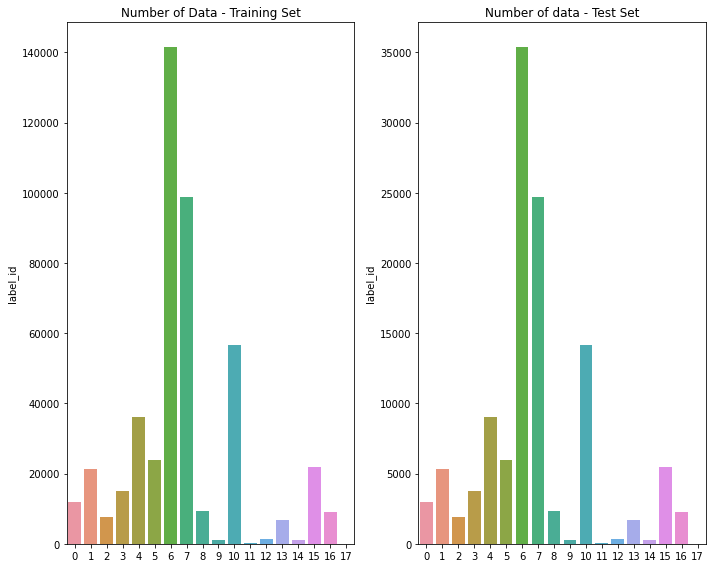

In [44]:
# Plot the observation to visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
sns.barplot(x=sorted(y_train.unique()), y=y_train.groupby(y_train).count(), ax=ax1).set_title('Number of Data - Training Set')
sns.barplot(x=sorted(y_test.unique()), y=y_test.groupby(y_test).count(), ax=ax2).set_title('Number of data - Test Set')
fig.tight_layout()
plt.show()

In [44]:
# Classifiers
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# https://towardsdatascience.com/multinomial-naive-bayes-classifier-for-text-analysis-python-8dd6825ece67
# https://www.freecodecamp.org/news/how-to-extract-keywords-from-text-with-tf-idf-and-pythons-scikit-learn-b2a0f3d7e667/
# https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

In [47]:
# Multinomial Naive Bayes model
pipeline_mnb = Pipeline(steps = [('TfIdf', TfidfVectorizer()),
                              ('MultinomialNB', MultinomialNB())])

In [48]:
# Parameter values to test
param_grid = {
 'TfIdf__max_features' : [5000, 6000, 7000],
 'TfIdf__ngram_range' : [(1,1)],
 'TfIdf__use_idf' : [True],
 'MultinomialNB__alpha' : [0.01, 0.02, 0.05, 0.10]
}

In [49]:
grid_search_mnb = GridSearchCV(pipeline_mnb, param_grid, cv=5, verbose=1, n_jobs=6)

In [50]:
grid_search_mnb.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed: 19.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('TfIdf', TfidfVectorizer()),
                                       ('MultinomialNB', MultinomialNB())]),
             n_jobs=6,
             param_grid={'MultinomialNB__alpha': [0.01, 0.02, 0.05, 0.1],
                         'TfIdf__max_features': [5000, 6000, 7000],
                         'TfIdf__ngram_range': [(1, 1)],
                         'TfIdf__use_idf': [True]},
             verbose=1)

In [51]:
grid_search_mnb.best_params_

{'MultinomialNB__alpha': 0.05,
 'TfIdf__max_features': 7000,
 'TfIdf__ngram_range': (1, 1),
 'TfIdf__use_idf': True}

In [52]:
grid_search_mnb.best_estimator_

Pipeline(steps=[('TfIdf', TfidfVectorizer(max_features=7000)),
                ('MultinomialNB', MultinomialNB(alpha=0.05))])

In [53]:
grid_search_mnb.score(X_test, y_test)

0.7106922579253828

In [54]:
predicted = grid_search_mnb.predict(X)
df_processed['Predicted_Category_MNB'] = predicted

In [55]:
y_predicted = grid_search_mnb.predict(X_test)

In [57]:
key_to_label_name = [x[1] for x in sorted(label_map.items())]

In [58]:
classification_report_mnb = classification_report(y_test, y_predicted, target_names=key_to_label_name)
print(classification_report_mnb)

e:\springboard\works\support_ticket_label_classification\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.68      0.16      0.26      2974
                                                 Checking or savings account       0.58      0.71      0.64      5343
                                                               Consumer Loan       0.49      0.09      0.15      1889
                                                                 Credit card       0.74      0.07      0.12      3752
                                                 Credit card or prepaid card       0.55      0.75      0.64      9036
                                                            Credit reporting       0.76      0.03      0.06      5987
Credit reporting, credit repair services, or other personal consumer reports       0.69      0.86      0.77     35373
                                                       

In [59]:
def plotConfusionMatrixHeatmap(input_df: pd.core.frame.DataFrame, model_name: str, figsize=(20, 18)):
    """
    Return the results of a multiclass classification algorithms as a heatmap
    based on a confusion matrix.        
    """
    # Heatmap of the results
    plt.figure(figsize=figsize)
    sns.heatmap(input_df, annot=True, fmt='d', cmap='Reds')
    plt.ylabel('True', fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold')
    plt.title(f'Confusion Matrix - {model_name}', size=14, fontweight='bold')
    plt.show()

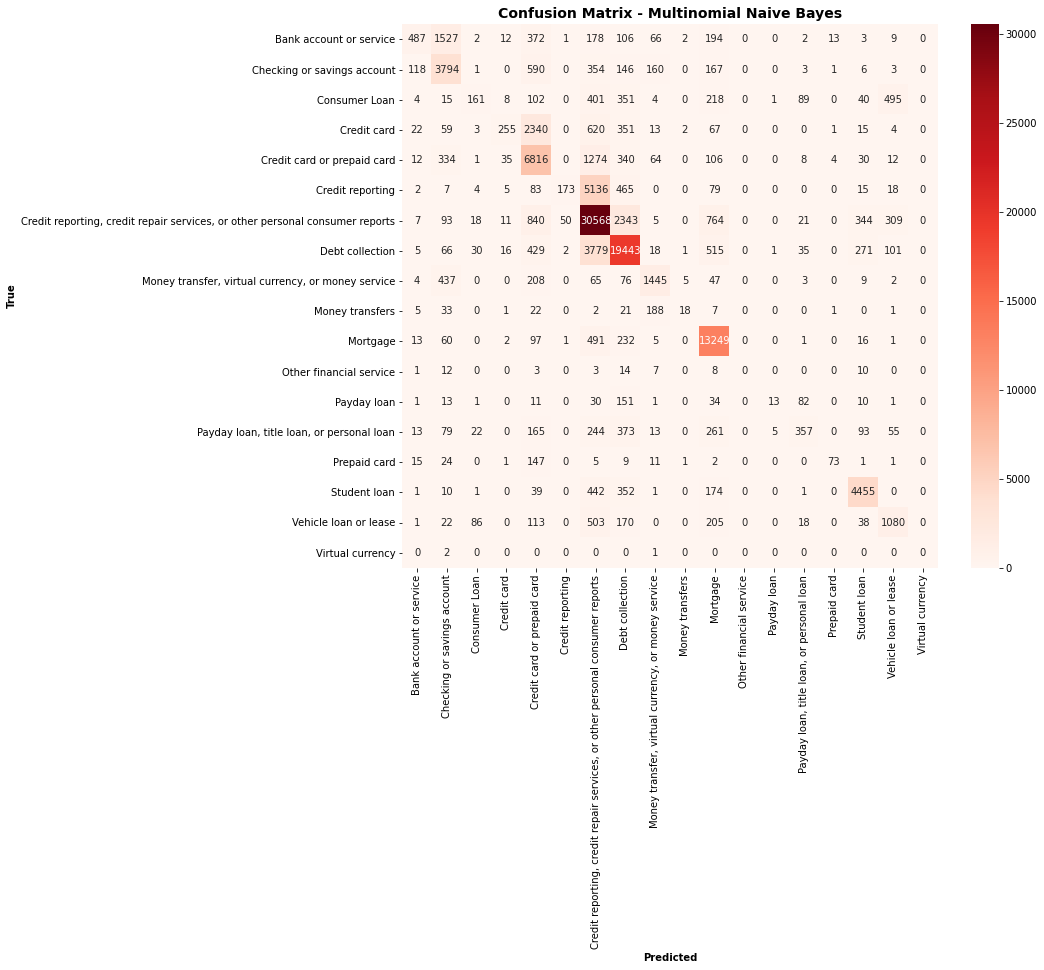

In [61]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Multinomial Naive Bayes', figsize=(12, 10))

In [62]:
# https://michael-fuchs-python.netlify.app/2019/11/11/introduction-to-sgd-classifier/
pipeline_lsvm = Pipeline(steps= [('TfIdf', TfidfVectorizer()),
                                 ('SGDC', SGDClassifier(verbose=1, random_state=42))])

In [63]:
# Parameter values to test
param_grid = {
 'TfIdf__max_features' : [None, 200, 300, 400],
 'TfIdf__ngram_range' : [(1,1)],
 'TfIdf__use_idf' : [True],
 'SGDC__loss' : ['hinge'],
 'SGDC__alpha' : [0.001, 0.01, 0.05, 0.1]
}

In [64]:
grid_search_svc = GridSearchCV(pipeline_lsvm, param_grid, cv=10, verbose=1, n_jobs=6)

In [65]:
grid_search_svc.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 160 out of 160 | elapsed: 70.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 0.33, NNZs: 27541, Bias: -1.004592, T: 463696, Avg. loss: 0.051451
Total training time: 0.39 seconds.
-- Epoch 2
Norm: 0.30, NNZs: 30414, Bias: -1.003056, T: 927392, Avg. loss: 0.051268
Total training time: 0.67 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 31767, Bias: -1.002476, T: 1391088, Avg. loss: 0.051259
Total training time: 1.00 seconds.
-- Epoch 4
Norm: 0.28, NNZs: 32584, Bias: -1.002089, T: 1854784, Avg. loss: 0.051254
Total training time: 1.27 seconds.
-- Epoch 5
Norm: 0.28, NNZs: 33116, Bias: -1.001856, T: 2318480, Avg. loss: 0.051252
Total training time: 1.55 seconds.
-- Epoch 6
Norm: 0.28, NNZs: 33510, Bias: -1.001705, T: 2782176, Avg. loss: 0.051251
Total training time: 1.83 seconds.
Convergence after 6 epochs took 1.84 seconds
-- Epoch 1
Norm: 1.17, NNZs: 35649, Bias: -1.047169, T: 463696, Avg. loss: 0.091179
Total training time: 0.28 seconds.
-- Epoch 2
Norm: 1.13, NNZs: 36844, Bias: -1.043991, T: 927392, Avg. loss: 0.091014
Total training time: 0.63 seconds.

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   32.8s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('TfIdf', TfidfVectorizer()),
                                       ('SGDC',
                                        SGDClassifier(random_state=42,
                                                      verbose=1))]),
             n_jobs=6,
             param_grid={'SGDC__alpha': [0.001, 0.01, 0.05, 0.1],
                         'SGDC__loss': ['hinge'],
                         'TfIdf__max_features': [None, 200, 300, 400],
                         'TfIdf__ngram_range': [(1, 1)],
                         'TfIdf__use_idf': [True]},
             verbose=1)

In [66]:
grid_search_svc.best_params_

{'SGDC__alpha': 0.001,
 'SGDC__loss': 'hinge',
 'TfIdf__max_features': None,
 'TfIdf__ngram_range': (1, 1),
 'TfIdf__use_idf': True}

In [67]:
# Check the score on the training and test sets
grid_search_svc.score(X_test, y_test)

0.6815009704550355

In [69]:
predicted = grid_search_svc.predict(X)
df_processed['Predicted_Category_LSVM'] = predicted

In [70]:
y_predicted = grid_search_svc.predict(X_test)

In [72]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),index=key_to_label_name,
                              columns=key_to_label_name)

In [73]:
classification_rep = classification_report(y_test, y_predicted,target_names=key_to_label_name)
print(classification_rep)

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.62      0.05      0.09      2974
                                                 Checking or savings account       0.58      0.57      0.58      5343
                                                               Consumer Loan       0.34      0.01      0.02      1889
                                                                 Credit card       0.53      0.02      0.03      3752
                                                 Credit card or prepaid card       0.61      0.54      0.58      9036
                                                            Credit reporting       0.00      0.00      0.00      5987
Credit reporting, credit repair services, or other personal consumer reports       0.66      0.88      0.75     35373
                                                       

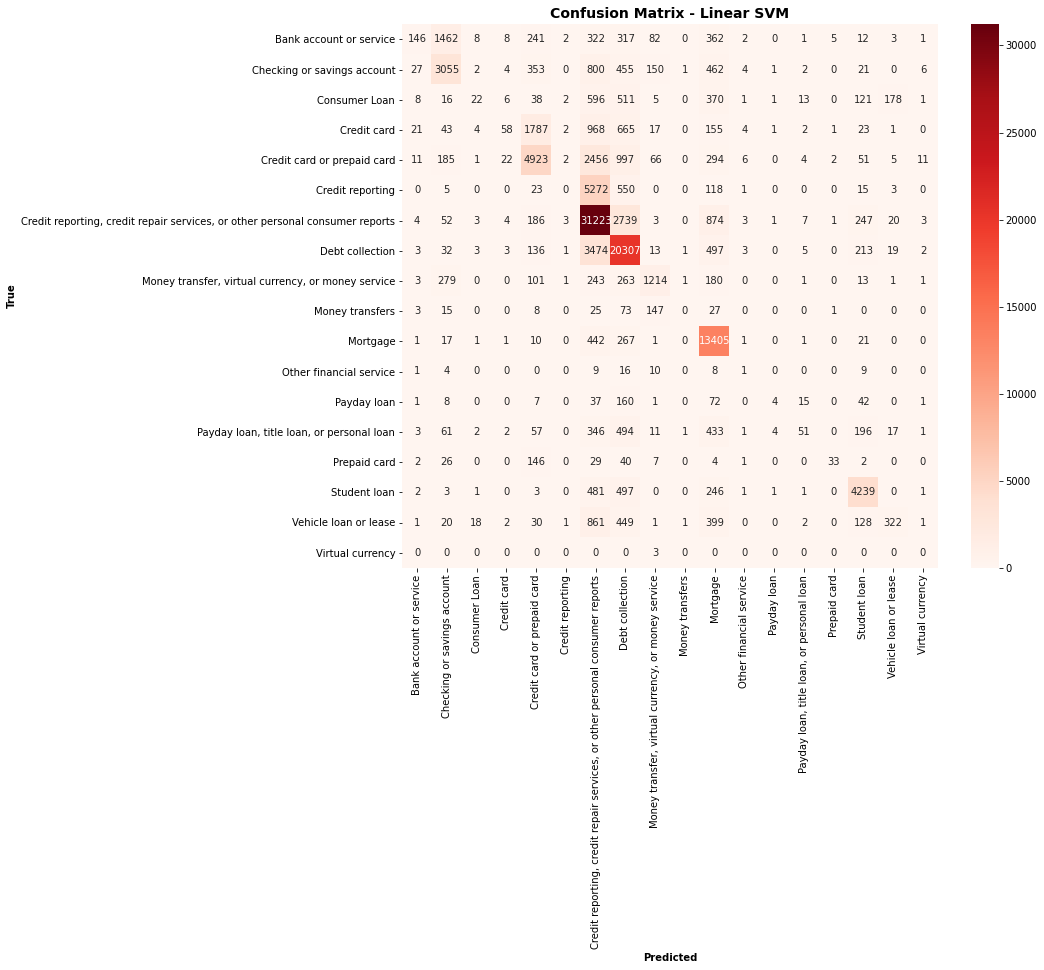

In [74]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Linear SVM', figsize=(12, 10))

#### 2

In [10]:
df_processed.sample()

,Unnamed: 0,full_text,submitted_via,sub_label,label,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,full_text_tokenized,full_text_lemmatized
36263,83176,I have been corresponding to XXXX/XXXX for sli...,Web,Other debt,Debt collection,974,402,441,0,4.752567,5623,217,"[corresponding, xxxx/xxxx, slightly, year, dis...",corresponding xxxx/xxxx slightly year disputed...


In [12]:
df_processed['label'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    176862
Debt collection                                                                 123561
Mortgage                                                                         70841
Credit card or prepaid card                                                      45178
Credit reporting                                                                 29936
Student loan                                                                     27380
Checking or savings account                                                      26715
Credit card                                                                      18757
Bank account or service                                                          14871
Money transfer, virtual currency, or money service                               11507
Vehicle loan or lease                                                            11179
Consumer Loan                              

In [17]:
label_category_map = {'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting',
                      'Credit card': 'Creditcard or prepaid card',
                      'Payday loan': 'Payday loan, title loan, or personal loan',
                      'Prepaid card': 'Credit card or prepaid card',
                      'Money transfers': 'Money transfer, virtual currency, or money service',
                      'Virtual currency': 'Money transfer, virtual currency, or money service'}

In [18]:
df_processed['label'].replace(label_category_map, inplace=True)

In [19]:
df_processed['label'].value_counts()

Credit reporting                                      206798
Debt collection                                       123561
Mortgage                                               70841
Credit card or prepaid card                            46626
Student loan                                           27380
Checking or savings account                            26715
Creditcard or prepaid card                             18757
Bank account or service                                14871
Money transfer, virtual currency, or money service     13017
Vehicle loan or lease                                  11179
Payday loan, title loan, or personal loan              10141
Consumer Loan                                           9444
Other financial service                                  291
Name: label, dtype: int64

In [20]:
# Pickle the file so we do not need to reprocess each time
pickle_df_filename = 'ticket_data_processed.pkl'
pickled_file_loc = os.path.join('../../data/', pickle_df_filename)

In [21]:
# df to pickle
df_processed.to_pickle(pickled_file_loc)

In [35]:
df_processed = pd.read_pickle(pickled_file_loc)

In [36]:
df_processed.sample()

,Unnamed: 0,full_text,submitted_via,sub_label,label,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,full_text_tokenized,full_text_lemmatized
375823,1464801,In XXXX of 2015 we received from Wells Fargo B...,Web,Conventional fixed mortgage,Mortgage,286,154,151,0,4.206294,1489,22,"[received, wells, fargo, bank, advertisement, ...",received well fargo bank advertisement refinan...


In [37]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df_processed['label_id'] = label_encoder.fit_transform(df_processed['label'])

In [38]:
# Put the label category into dict for future use
label_map = df_processed.set_index('label_id').to_dict()['label']
label_map

{6: 'Debt collection',
 4: 'Credit reporting',
 3: 'Credit card or prepaid card',
 1: 'Checking or savings account',
 7: 'Money transfer, virtual currency, or money service',
 12: 'Vehicle loan or lease',
 8: 'Mortgage',
 11: 'Student loan',
 5: 'Creditcard or prepaid card',
 10: 'Payday loan, title loan, or personal loan',
 2: 'Consumer Loan',
 9: 'Other financial service',
 0: 'Bank account or service'}

In [39]:
validation_data = df_processed.sample(frac=0.20)

In [40]:
df = df_processed.drop(validation_data.index)

In [41]:
validation_data.shape

(115924, 15)

In [42]:
df.shape

(463697, 15)

In [43]:
# Select X & y data from dataframe
X = df['full_text_lemmatized']
y = df['label_id']

In [45]:
# Split train test data with 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Multinomial Naive Bayes model
pipeline_mnb = Pipeline(steps = [('TfIdf', TfidfVectorizer()),
                              ('MultinomialNB', MultinomialNB())])

In [ ]:
# Parameter values to test
param_grid = {
 'TfIdf__max_features' : [5000, 6000, 7000],
 'TfIdf__ngram_range' : [(1,1)],
 'TfIdf__use_idf' : [True],
 'MultinomialNB__alpha' : [0.01, 0.02, 0.05, 0.10]
}

In [ ]:
grid_search_mnb = GridSearchCV(pipeline_mnb, param_grid, cv=5, verbose=1, n_jobs=6)

In [ ]:
grid_search_mnb.fit(X_train, y_train)

In [ ]:
grid_search_mnb.best_params_

In [ ]:
grid_search_mnb.best_estimator_